In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
#import seaborn as sns

from network import Net
from diff_equations import *
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Text(0.5, 0, 'Time (s)')

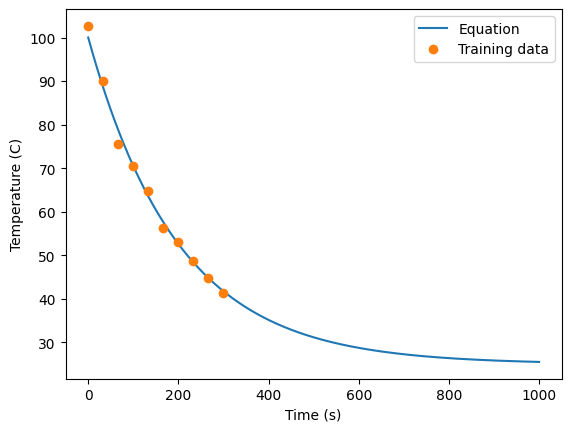

In [7]:
np.random.seed(10)

Tenv = 25
T0 = 100
R = 0.005
times = np.linspace(0, 1000, 1000)
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, R=R)
temps = eq(times)

# Make training data
t = np.linspace(0, 300, 10)
T = eq(t) +  2 * np.random.randn(10)

plt.plot(times, temps)
plt.plot(t, T, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

In [8]:
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = R*(Tenv - temps) - dT
    
    return torch.mean(pde**2)

Epoch 0/30000, loss: 4919.99
Epoch 3000/30000, loss: 2371.80
Epoch 6000/30000, loss: 246.99
Epoch 9000/30000, loss: 2.36
Epoch 12000/30000, loss: 2.10
Epoch 15000/30000, loss: 1.70
Epoch 18000/30000, loss: 1.44
Epoch 21000/30000, loss: 1.35
Epoch 24000/30000, loss: 1.33
Epoch 27000/30000, loss: 1.33


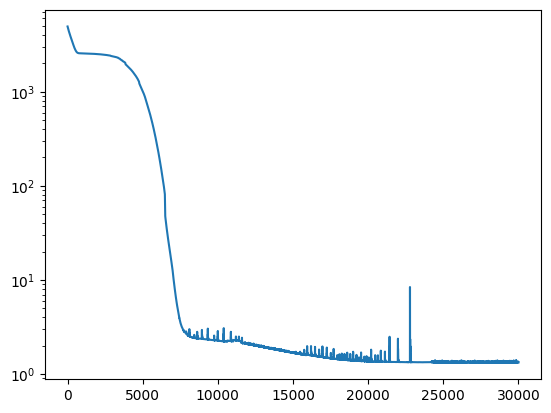

In [9]:
net = Net(1,1, loss2=physics_loss, epochs=30000, loss2_weight=1, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)
plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

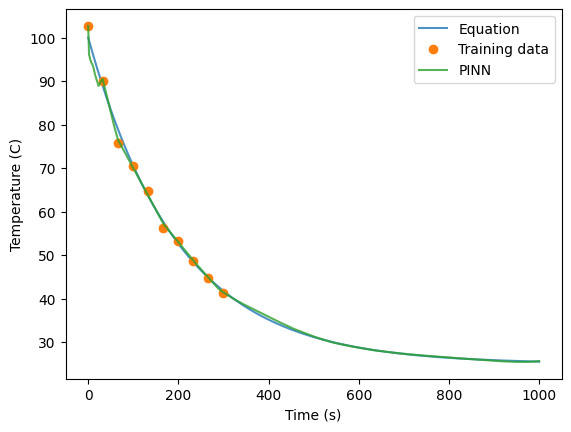

In [10]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

---

# Comparing NN vs PINN for 1D problem

The example problem we solve here is the 1D damped harmonic oscillator:

$$
m \frac{d^2x}{dt^2} + \mu \frac{dx}{dt} + kx = 0,
$$

with the initial conditions

$$
x(0) = 1, \quad \frac{dx}{dt} = 0.
$$

In [2]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os

In [3]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

In [4]:
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

In [6]:
class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

## generate training data

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


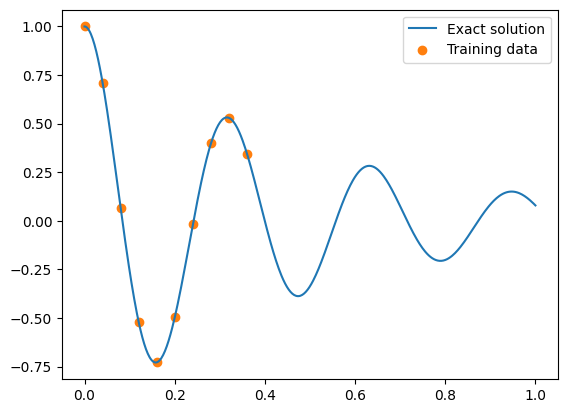

In [7]:
d, w0 = 2, 20

# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
#TRAINING DATA
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()
# Create directory for saving plots
save_dir = "C:\\Users\\nikhi\\thesis_local\\plots"
os.makedirs(save_dir, exist_ok=True)

In [8]:
#normal NN
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")

## NN implemetation

Epoch 99, Loss: 0.28657931089401245
Epoch 199, Loss: 0.038655731827020645
Epoch 299, Loss: 0.007702446077018976
Epoch 399, Loss: 0.0018727139104157686
Epoch 499, Loss: 0.000486351695144549
Epoch 599, Loss: 0.0002735398884397
Epoch 699, Loss: 0.00021554312843363732
Epoch 799, Loss: 0.0001846037630457431
Epoch 899, Loss: 0.00016080858767963946
Epoch 999, Loss: 0.00013938426855020225
Epoch 1099, Loss: 0.00011898643424501643
Epoch 1199, Loss: 0.00010051700519397855
Epoch 1299, Loss: 8.296514715766534e-05
Epoch 1399, Loss: 6.682580715278164e-05
Epoch 1499, Loss: 5.1833711040671915e-05
Epoch 1599, Loss: 4.309961514081806e-05
Epoch 1699, Loss: 2.7875803425558843e-05
Epoch 1799, Loss: 1.9525843526935205e-05
Epoch 1899, Loss: 5.5225489631993696e-05
Epoch 1999, Loss: 9.195567145070527e-06
Epoch 2099, Loss: 6.3962152125895955e-06
Epoch 2199, Loss: 5.7651532188174315e-06
Epoch 2299, Loss: 3.2888867735891836e-06
Epoch 2399, Loss: 2.4342652977793477e-06
Epoch 2499, Loss: 1.8960305396831245e-06
Epoch

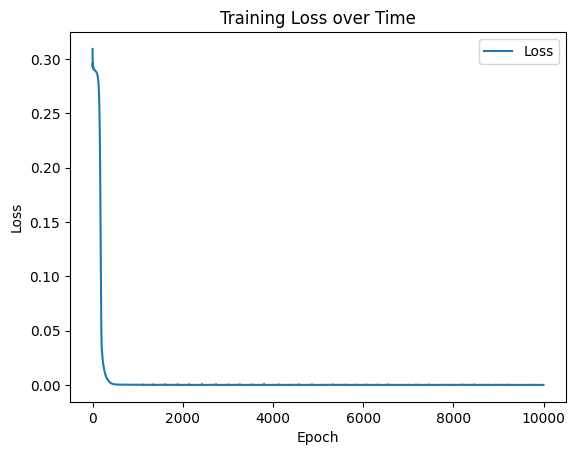

In [9]:
# train standard neural network to fit training data
torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
losses =[]

for i in range(10000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if (i+1) % 100 == 0:
        print(f'Epoch {i}, Loss: {loss.item()}')

plt.figure()
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.legend()
plt.show() 

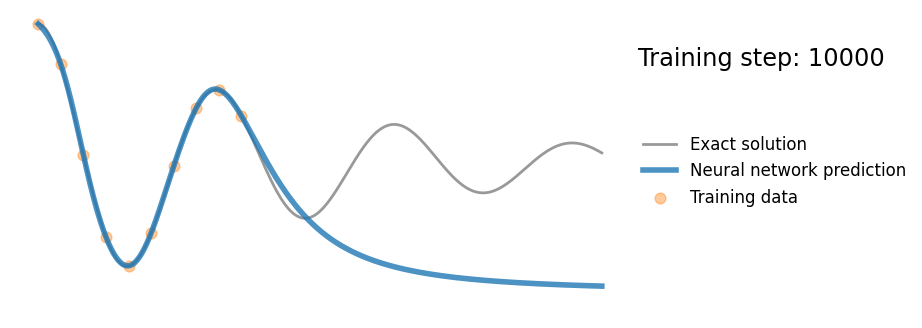

In [10]:
if (i+1) % 10 == 0: 
        
        yh = model(x).detach()
        
        plot_result(x,y,x_data,y_data,yh)
        
        file = os.path.join(save_dir, "nn_%.8i.png"%(i+1))
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL(os.path.join(save_dir, "nn.gif"), files, fps=20, loop=0)

## PINN implementation
We add the underlying physics equation

$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0
$$
or
$$
m \dfrac{d^2 xy}{d x^2} + \mu \dfrac{d y}{d x} + ky = 0
$$

 gradients of the network’s output with respect to its input are computed at these locations (which are typically analytically available for most neural networks, and can be easily computed using autodifferentiation).

In [11]:
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# sample locations over the problem domain
mu, k = 2*d, w0**2

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []
losses2 = []




Epoch 999, Loss of PINN: 0.0019222493283450603
Epoch 1999, Loss of PINN: 0.0007134010083973408
Epoch 2999, Loss of PINN: 0.00040924487984739244
Epoch 3999, Loss of PINN: 0.0003372045757714659
Epoch 4999, Loss of PINN: 0.00030856378725729883
Epoch 5999, Loss of PINN: 0.0002908855094574392
Epoch 6999, Loss of PINN: 0.0002797729102894664
Epoch 7999, Loss of PINN: 0.0002704434155020863
Epoch 8999, Loss of PINN: 0.00026311600231565535
Epoch 9999, Loss of PINN: 0.0002566917391959578
Epoch 10999, Loss of PINN: 0.00025118119083344936
Epoch 11999, Loss of PINN: 0.0002455242210999131
Epoch 12999, Loss of PINN: 0.0002412408503005281
Epoch 13999, Loss of PINN: 0.00023551270714960992
Epoch 14999, Loss of PINN: 0.00023080536630004644
Epoch 15999, Loss of PINN: 0.00022674119099974632
Epoch 16999, Loss of PINN: 0.00022173718025442213
Epoch 17999, Loss of PINN: 0.00022598155192099512
Epoch 18999, Loss of PINN: 0.0002127309562638402
Epoch 19999, Loss of PINN: 0.0002082870778394863


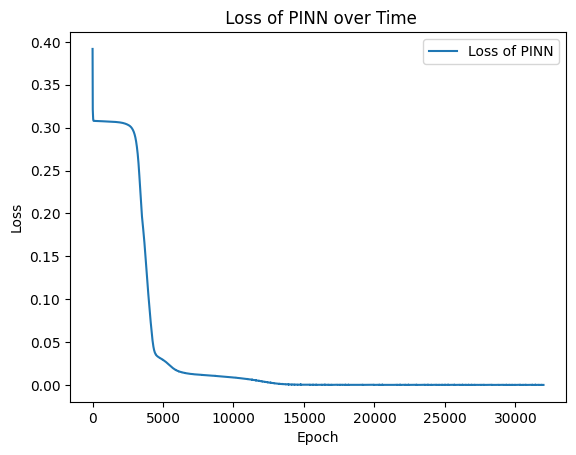

In [19]:

for i in range(20000):
    optimizer.zero_grad()
    #data loss similar to NN
    yh = model(x_data)
    loss1 = torch.mean((yh - y_data)**2)
 # compute the "physics loss" 
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
    loss2 = (1e-4)*torch.mean(physics**2) # scaling factor to balance physics los mit data loss
    # backpropagate joint loss
    loss = loss1 + loss2# add two loss terms together
    loss.backward()
    optimizer.step()
    losses2.append(loss.item())

    if (i+1) % 1000 == 0:
            print(f'Epoch {i}, Loss of PINN: {loss.item()}')

plt.figure()
plt.plot(losses2, label='Loss of PINN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(' Loss of PINN over Time')
plt.legend()
plt.show() 

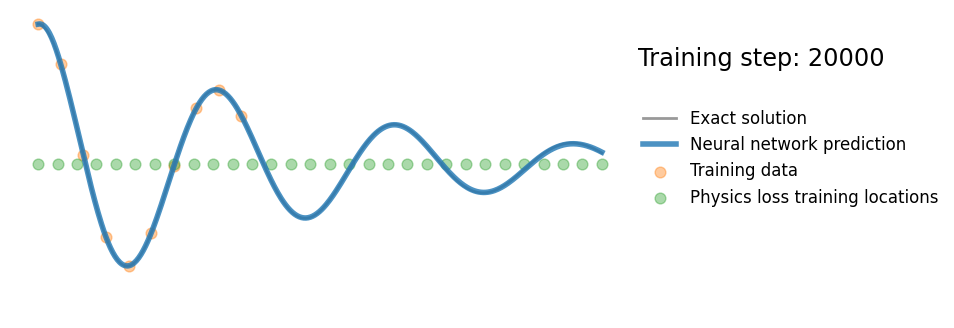

In [20]:
if (i+1) % 10 == 0: 
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        plot_result(x,y,x_data,y_data,yh,xp)
        
        file = os.path.join(save_dir, "pinn_%.8i.png"%(i+1))
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (i+1) % 100 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL(os.path.join(save_dir, "pinn.gif"), files, fps=20, loop=0)

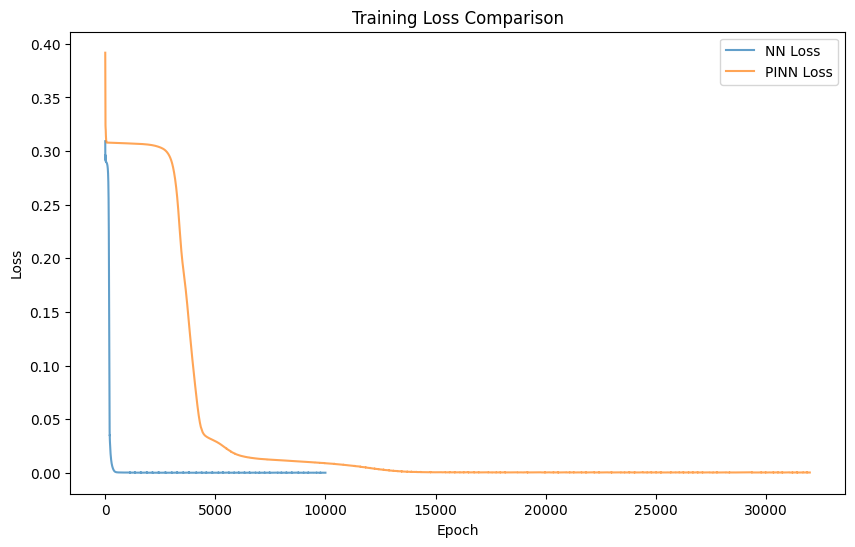

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(losses, label='NN Loss', alpha=0.7)
plt.plot(losses2, label='PINN Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()
